In [1]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [2]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

2023-03-06 10:35:53.981686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 10:35:54.035699: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 10:35:54.296515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victorxesus.barreiro/anaconda3/envs/deepgpu4/lib/
2023-03-06 10:35:54.296546: W tensorflow/

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Image shape:  (32, 32, 3)
Label:  44


2023-03-06 10:35:54.657403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 10:35:54.659621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 10:35:54.659686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 10:35:54.659896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

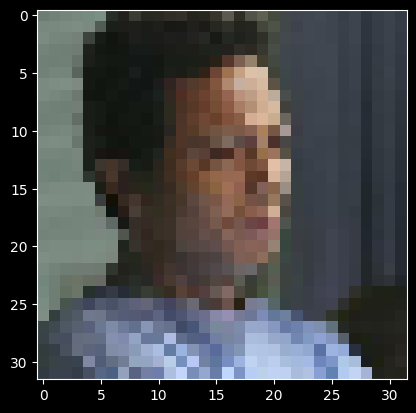

Image shape:  (32, 32, 3)
Label:  38


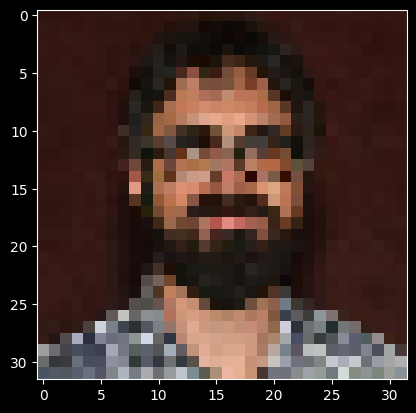

Image shape:  (32, 32, 3)
Label:  34


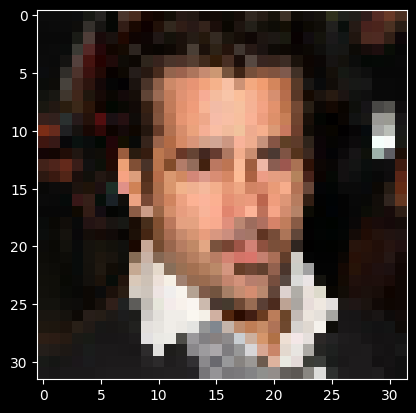

Image shape:  (32, 32, 3)
Label:  28


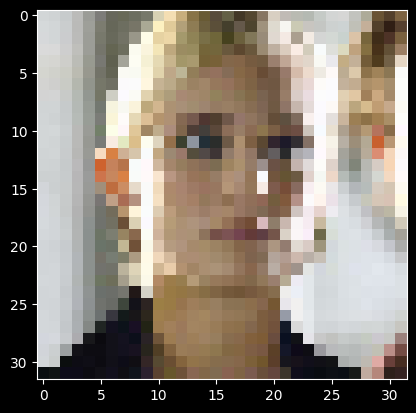

Image shape:  (32, 32, 3)
Label:  45


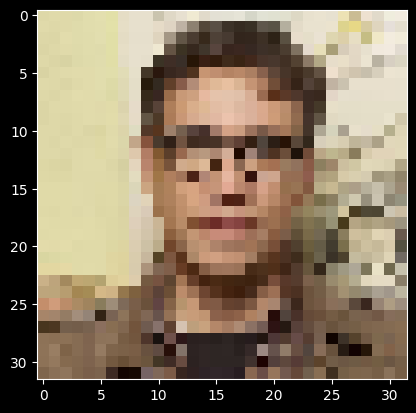

In [4]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [5]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [6]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

In [8]:
# OPTIONAL: sample age weights
import numpy as np
step = 10
labels = [int(x.split('|')[1]) for x in train_metadata]
freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

tf.Tensor(
[1.76150383 0.08628557 0.01546083 0.01225852 0.01755069 0.03502511
 0.06879879 0.16056922 0.52553153 7.31701591], shape=(10,), dtype=float64)


In [9]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

# Modelos

Cargamos el modelo para recuperar el extractor de caracteristicas.

In [11]:
loaded_model = tf.keras.models.load_model("prueba_age.h5")

In [12]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13, 64)       256 

In [22]:
loaded_model.layers[10]

In [31]:
import tensorflow as tf
from tensorflow import keras


loaded_model.trainable =  False

from tensorflow.keras import Sequential
new_model = Sequential()
for layer in loaded_model.layers[:-1]:
    new_model.add(layer)



In [32]:
from tensorflow.keras.layers import Dense

new_model.add(Dense(1, activation='sigmoid'))

In [33]:
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                      